# Preliminaries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt
from matplotlib import cm
import msgpack

from stellarpunk import econ_sim, serialization

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stellarpunk.serialization
%aimport stellarpunk.econ_sim

# Data Loading

## Economic Model

In [3]:
#production_chain_df = pd.DataFrame(msgpack.unpackb(open("/tmp/production_chain.log", "rb").read(), object_hook=serialization.decode_matrix))
production_chain = serialization.load_production_chain(open("/tmp/production_chain.log", "rb").read())
production_chain_df = production_chain.adj_matrix

In [4]:
production_chain_df.shape

(28, 28)

In [5]:
agent_goods_df = pd.DataFrame(msgpack.unpackb(open("/tmp/agent_goods.log", "rb").read(), object_hook=serialization.decode_matrix))

In [6]:
agent_goods_df.sum(axis=0)

0     26.0
1     47.0
2     17.0
3     69.0
4     18.0
5     18.0
6     20.0
7      8.0
8     41.0
9     10.0
10     1.0
11     2.0
12     1.0
13     1.0
14     1.0
15     3.0
16     2.0
17     3.0
18     3.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
dtype: float64

In [7]:
np.where(agent_goods_df.loc[31] == 1)

(array([8]),)

In [8]:
agent_goods_df.idxmax(axis=1).loc[146]

3

In [9]:
production_goods = agent_goods_df @ production_chain_df.T

## Loading Other Data

In [10]:
buy_price_df = serialization.read_tick_log_to_df(open("/tmp/buy_prices.log", "rb"), index_name="agent").reset_index()
buy_budget_df = serialization.read_tick_log_to_df(open("/tmp/buy_budget.log", "rb"), index_name="agent").reset_index()
sell_price_df = serialization.read_tick_log_to_df(open("/tmp/sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()
max_buy_price_df = serialization.read_tick_log_to_df(open("/tmp/max_buy_prices.log", "rb"), index_name="agent").reset_index()
min_sell_price_df = serialization.read_tick_log_to_df(open("/tmp/min_sell_prices.log", "rb"), index_name="agent", fill_values=np.inf).reset_index()

In [11]:
columns = ["tick", "product", "buyer", "seller", "price", "amount"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [12]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [13]:
cannot_buy_df = serialization.read_tick_log_to_df(open("/tmp/cannot_buy.log", "rb"), index_name="agent", fill_values=0.).reset_index()
cannot_sell_df = serialization.read_tick_log_to_df(open("/tmp/cannot_sell.log", "rb"), index_name="agent", fill_values=0.).reset_index()

In [14]:
balance_df = serialization.read_tick_log_to_df(open("/tmp/balance.log", "rb"), index_name="agent", column_names=["balance"])
balance_df.reset_index(inplace=True)

In [15]:
#columns = list(map(lambda x: str(x), range(production_chain_df.shape[0])))
columns=None
inventory_df = serialization.read_tick_log_to_df(open("/tmp/inventory.log", "rb"), index_name="agent", column_names=columns)
inventory_df.reset_index(inplace=True)

In [16]:
#production_efficiency_df = serialization.read_tick_log_to_df(open("/tmp/production_efficiency.log", "rb"), index_name="agent")

# Transactions

## Market Overview

In [17]:
transaction_df.groupby("product")[["amount", "value"]].sum()

,amount,value
product,,
-1,26596302.0,2.393507e+08
0,5120939.0,4.102536e+07
1,7600768.0,5.920736e+07
2,4723338.0,7.447222e+07
3,3784389.0,7.138033e+06
4,4530958.0,5.893798e+07
5,5077519.0,6.166921e+07
6,7493020.0,6.669039e+07
7,4689946.0,9.429047e+07


592418 transactions total


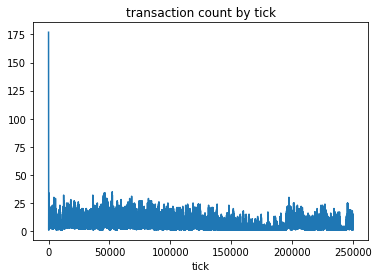

In [18]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")
print(f'{len(transaction_df)} transactions total')

Text(0.5, 1.0, 'product 0 transaction count per tick')

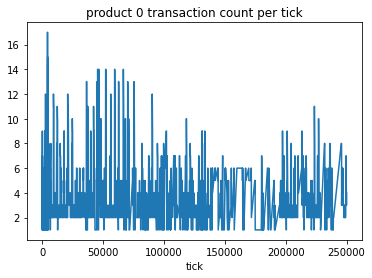

In [19]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

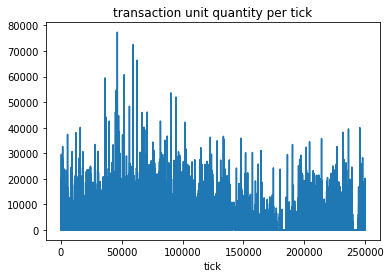

In [20]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

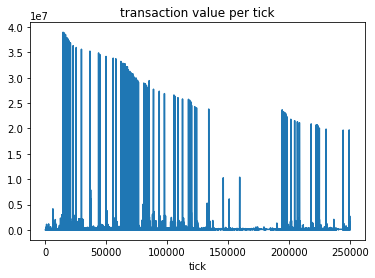

In [21]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

Text(0.5, 1.0, 'distinct products sold per tick')

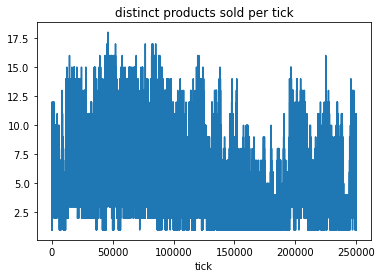

In [22]:
transaction_df.groupby("tick")["product"].nunique().plot()
plt.title("distinct products sold per tick") 

Text(0.5, 1.0, 'distinct sellers per tick')

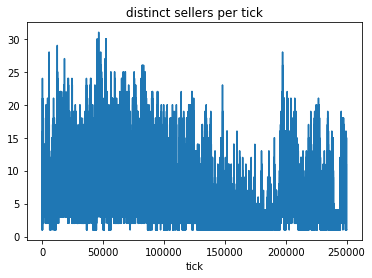

In [23]:
transaction_df.groupby("tick")["seller"].nunique().plot()
plt.title("distinct sellers per tick")

Text(0.5, 1.0, 'distinct buyers per tick')

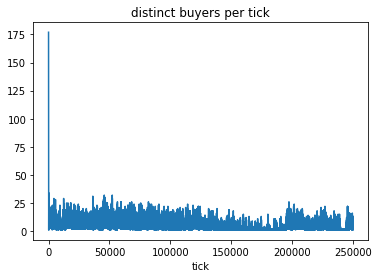

In [24]:
transaction_df.groupby("tick")["buyer"].nunique().plot()
plt.title("distinct buyers per tick")

In [25]:
transaction_df["seller"].nunique()

301

In [26]:
transaction_df["buyer"].nunique()

301

In [27]:
transaction_df["product"].nunique()

29

<AxesSubplot:>

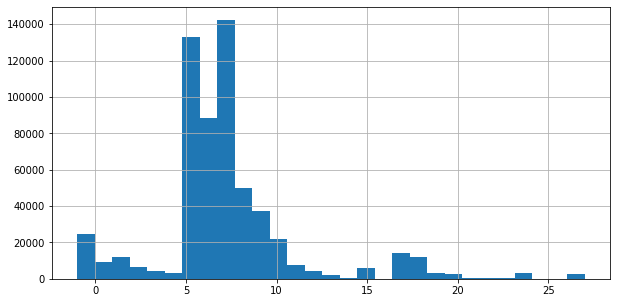

In [28]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].nunique())

Text(0.5, 1.0, 'max product id sold each tick')

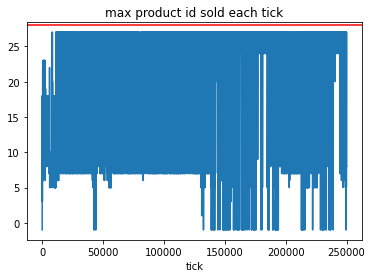

In [29]:
transaction_df.groupby("tick")["product"].max().plot()
plt.axhline(production_chain_df.shape[1], color="red")
plt.title("max product id sold each tick")

## Further Exploration

In [30]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    70.000000
mean      1.800188
std       0.114859
min       1.721547
25%       1.748331
50%       1.770439
75%       1.810840
max       2.403469
Name: price, dtype: float64

Text(0.5, 1.0, 'price of product 0 over time')

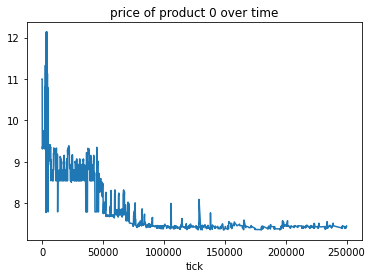

In [31]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean().plot()
plt.title("price of product 0 over time")

Text(0.5, 1.0, 'price of product 3 over time')

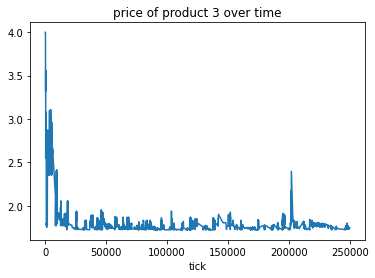

In [32]:
transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean().plot()
plt.title("price of product 3 over time")

<AxesSubplot:>

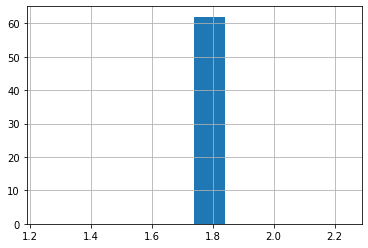

In [33]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

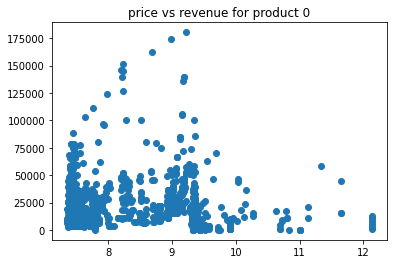

In [34]:
plt.scatter(transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 0].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 0")
plt.show()

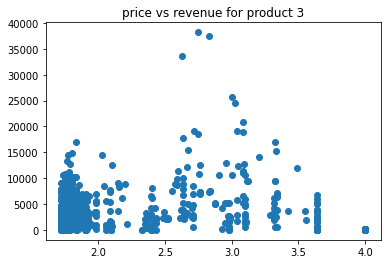

In [35]:
plt.scatter(transaction_df[transaction_df["product"] == 3].groupby("tick")["price"].mean(), transaction_df[transaction_df["product"] == 3].groupby("tick")["value"].sum())
plt.title("price vs revenue for product 3")
plt.show()

In [36]:
transaction_df[(transaction_df["price"] > 12) & (transaction_df["product"] == 0)]

,tick,product,buyer,seller,price,amount,value
13433,2702,0,98,184,12.128919,1301.0,15779.723285
13434,2702,0,5,236,12.127191,1279.0,15510.676793
13825,2775,0,98,286,12.128919,625.0,7580.574215
13826,2775,0,5,195,12.127191,649.0,7870.546707
14174,2848,0,98,184,12.128919,18.0,218.320537
14175,2848,0,5,236,12.127191,87.0,1055.065583
14509,2921,0,98,276,12.128919,1.0,12.128919
15269,3140,0,98,286,12.128919,1821.0,22086.761032
15270,3140,0,5,171,12.127191,1817.0,22035.105342
15920,3286,0,98,236,12.128919,510.0,6185.748559


In [37]:
transaction_df.groupby("product").agg({"tick":"max", "price":"mean", "amount":"sum", "value":"sum"})

,tick,price,amount,value
product,,,,
-1,249957,9.004435e+00,26596302.0,2.393507e+08
0,249953,8.052326e+00,5120939.0,4.102536e+07
1,249956,7.820037e+00,7600768.0,5.920736e+07
2,249953,1.584456e+01,4723338.0,7.447222e+07
3,249953,1.940294e+00,3784389.0,7.138033e+06
4,248420,1.328641e+01,4530958.0,5.893798e+07
5,249955,1.307159e+01,5077519.0,6.166921e+07
6,249881,9.424171e+00,7493020.0,6.669039e+07
7,249299,2.073309e+01,4689946.0,9.429047e+07


## Transaction Graph

### By Agent

In [38]:
transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index()

,buyer,seller,amount
0,-1,25,53.0
1,-1,26,70.0
2,-1,27,2912.0
3,0,-1,212775.0
4,1,-1,122297.0
...,...,...,...
2892,299,215,2279.0
2893,299,222,503.0
2894,299,249,1.0
2895,299,251,10.0


In [39]:
G = nx.from_pandas_edgelist(
    transaction_df.groupby(["buyer", "seller"])["amount"].sum().to_frame().reset_index(),
    source="seller", target="buyer", edge_attr="amount", create_using=nx.DiGraph)

In [40]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [41]:
G = nx.relabel_nodes(G, labels)

In [42]:
nx.is_directed_acyclic_graph(G)

False

In [43]:
# this is pretty slow for lots of agents
#plt.figure(figsize=(15, 15))
#pos = graphviz_layout(G, prog='dot')
#nx.draw(G, pos, with_labels=True, arrows=True)
#nx.draw_networkx_edge_labels(G, pos)
#plt.show()

### By Good

In [44]:
augmented_transaction_df = transaction_df.merge(agent_goods_df.idxmax(axis=1).rename("buyer_product"), how="left", left_on="buyer", right_index=True)
augmented_transaction_df["buyer_product"].fillna(-2, inplace=True)
product_flow = augmented_transaction_df.groupby(["product", "buyer_product"])["value"].sum().to_frame().reset_index().rename({"buyer_product":"target", "product":"source", "amount":"value"}, axis=1)

In [45]:
agent_goods_df.columns

RangeIndex(start=0, stop=28, step=1)

In [46]:
set(agent_goods_df.columns) - set(product_flow["source"].unique())

set()

In [47]:
set(agent_goods_df.columns) - set(product_flow["target"].unique())

set()

In [48]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
sankey = SankeyWidget(layout=Layout(height='680', width='1024'), links=product_flow.to_dict("records"))
sankey

SankeyWidget(layout=Layout(height='680', width='1024'), links=[{'source': -1, 'target': 0.0, 'value': 39690418…

In [49]:
from IPython.display import (
    Image,
    SVG
)
import base64
data = base64.decodebytes(bytes(sankey.png, 'ascii'))
Image(data)

## Indicators by Market

In [50]:
transactions_by_product = pd.DataFrame({"producers":agent_goods_df.sum(axis=0), "sellers":transaction_df.groupby("product")["seller"].nunique()})
transactions_by_product["zero_sales"] = transactions_by_product["producers"] - transactions_by_product["sellers"]
transactions_by_product["seller_value_cv"] = transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").std() / transaction_df.groupby(["product", "seller"])["value"].sum().groupby("product").mean()
transactions_by_product["transactions"] = transaction_df.groupby("product")["price"].count()
transactions_by_product["total_amount"] = transaction_df.groupby("product")["amount"].sum()
transactions_by_product["total_value"] = transaction_df.groupby("product")["value"].sum()
transactions_by_product["price"] = transaction_df.groupby("product")["price"].mean()
transactions_by_product["price_cv"] = transaction_df.groupby("product")["price"].std() / transaction_df.groupby("product")["price"].mean()
transactions_by_product["first_tick"] = transaction_df.groupby("product")["tick"].min()
transactions_by_product["last_tick"] = transaction_df.groupby("product")["tick"].max()

transactions_by_product

,producers,sellers,zero_sales,seller_value_cv,transactions,total_amount,total_value,price,price_cv,first_tick,last_tick
-1,NaN,1,NaN,NaN,24369,26596302.0,2.393507e+08,9.004435e+00,0.486476,0,249957
0,26.0,26,0.0,0.042982,9335,5120939.0,4.102536e+07,8.052326e+00,0.105831,74,249953
1,47.0,47,0.0,0.245179,11892,7600768.0,5.920736e+07,7.820037e+00,0.027930,74,249956
2,17.0,17,0.0,0.075900,6352,4723338.0,7.447222e+07,1.584456e+01,0.050038,74,249953
3,69.0,69,0.0,0.382486,4431,3784389.0,7.138033e+06,1.940294e+00,0.247266,74,249953
4,18.0,18,0.0,0.131194,3156,4530958.0,5.893798e+07,1.328641e+01,0.143858,74,248420
5,18.0,18,0.0,0.730124,133208,5077519.0,6.166921e+07,1.307159e+01,0.516011,75,249955
6,20.0,20,0.0,0.747017,88354,7493020.0,6.669039e+07,9.424171e+00,0.276081,81,249881
7,8.0,8,0.0,0.786371,142343,4689946.0,9.429047e+07,2.073309e+01,0.262449,75,249299
8,41.0,41,0.0,2.774148,50177,3656798.0,8.093923e+06,2.221229e+00,0.413828,85,250000


Text(0.5, 1.0, 'mean prices by products')

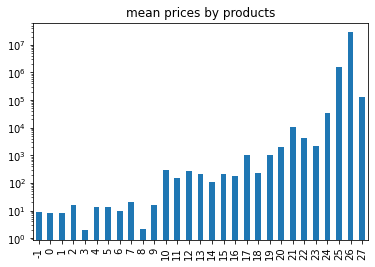

In [51]:
transactions_by_product["price"].plot.bar()
plt.yscale("log")
plt.title("mean prices by products")

Text(0.5, 1.0, 'cv by product')

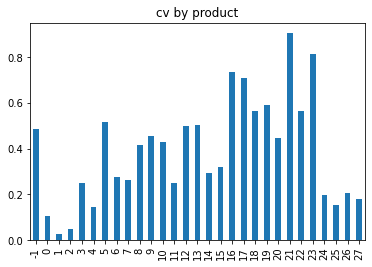

In [52]:
transactions_by_product["price_cv"].plot.bar()
plt.title("cv by product")

Text(0.5, 0.98, 'Prices for goods over time')

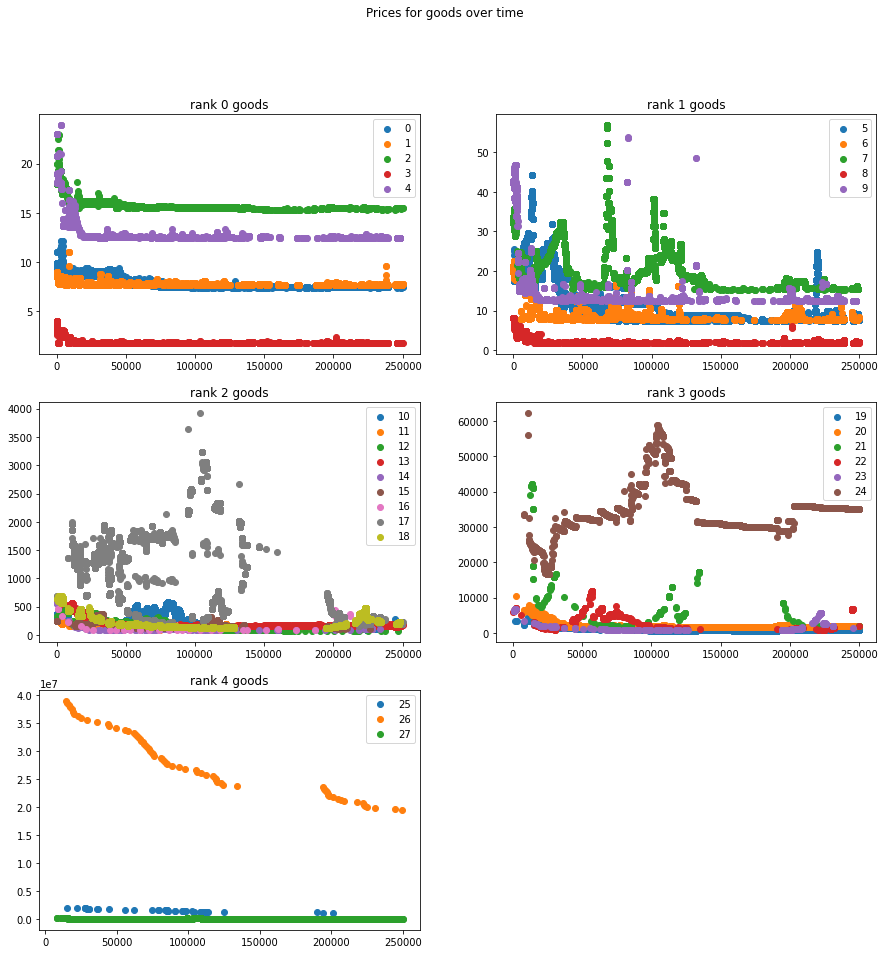

In [53]:
price_by_tick = transaction_df.groupby(["tick", "product"])["price"].mean().to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_by_tick[price_by_tick["product"] == product]["tick"], price_by_tick[price_by_tick["product"] == product]["price"], label=f'{product}')
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Prices for goods over time")

In [54]:
buy_price_melt = buy_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
buy_price_melt = buy_price_melt[buy_price_melt["price"] > 0]
buy_price_by_tick = buy_price_melt.groupby(["tick", "product"])["price"].max()
sell_price_melt = sell_price_df.melt(id_vars=["agent", "tick"], value_vars=list(range(production_chain.ranks.sum())), var_name="product", value_name="price")
sell_price_melt = sell_price_melt[sell_price_melt["price"] < np.inf]
sell_price_by_tick = sell_price_melt.groupby(["tick", "product"])["price"].min()

Text(0.5, 0.98, 'Buy/sell price diffs for goods over time')

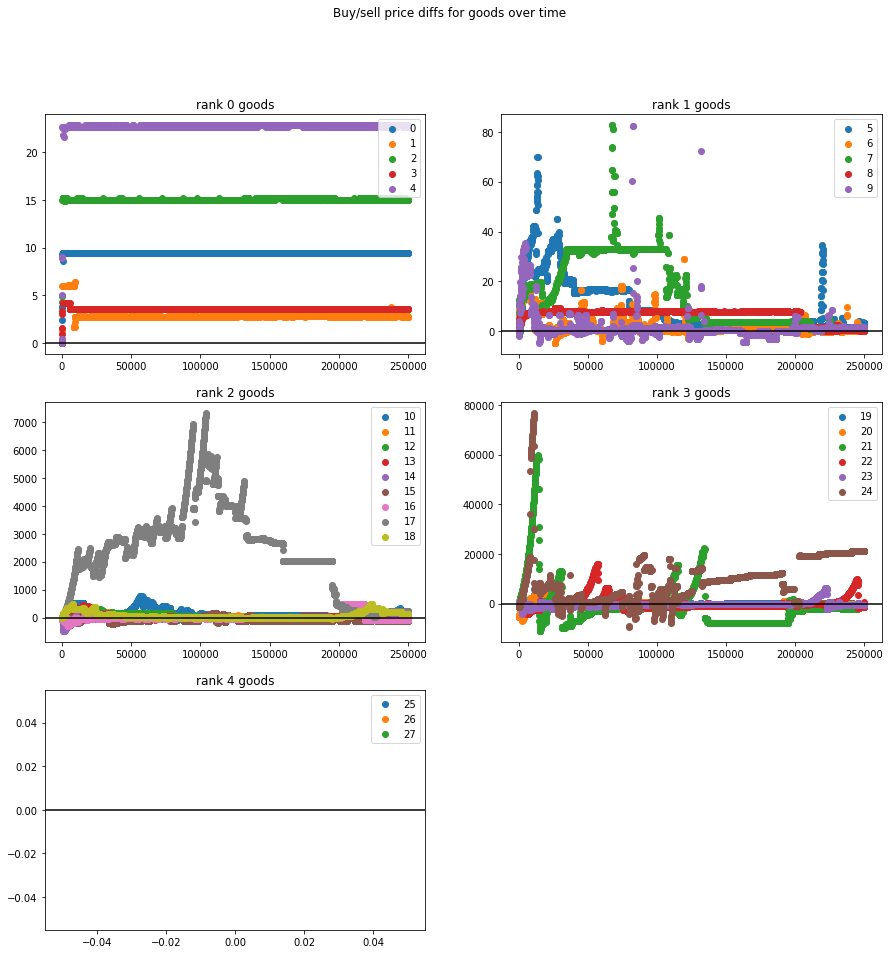

In [56]:
price_diffs = (buy_price_by_tick - sell_price_by_tick).to_frame().reset_index()

a = np.insert(production_chain.ranks.cumsum(), 0,0)
rank_ranges = list(zip(a[0:-1], a[1:]))

fig, axs = plt.subplots(int(np.ceil(len(rank_ranges)/2)),2, figsize=(15,15))
if len(rank_ranges) % 2 == 1:
    fig.delaxes(axs.flatten()[-1])
for i,rng in enumerate(rank_ranges):
    ax = axs.flatten()[i]
    for product in range(rng[0], rng[1]):
        ax.scatter(price_diffs[price_diffs["product"] == product]["tick"], price_diffs[price_diffs["product"] == product]["price"], label=f'{product}')
    ax.axhline(0, color="black")
    ax.title.set_text(f'rank {i} goods')
    ax.legend(loc="upper right")
    
fig.suptitle("Buy/sell price diffs for goods over time")

# Balance

In [57]:
balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")

,tick,balance
agent,,
0,0,1575.714341
1,0,1272.631332
2,0,2845.376861
3,0,582.610699
4,0,3324.451453
...,...,...
295,0,1272.631332
296,0,3324.451453
297,0,4800.000000


In [58]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")

,tick,balance
agent,,
0,249952,20836.432023
1,249952,306.908486
2,249952,8.977615
3,249952,0.831808
4,249952,21620.654263
...,...,...
295,249952,2.055872
296,249952,0.349317
297,249952,3.104188


In [59]:
#balance_df.groupby("tick")["balance"].sum().plot()

In [60]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    3.000000e+02
mean     7.183354e+06
std      1.126414e+08
min      5.826107e+02
25%      1.272631e+03
50%      2.845377e+03
75%      6.000000e+03
max      1.948549e+09
Name: balance, dtype: float64

In [61]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count    3.000000e+02
mean     1.444199e+07
std      1.962454e+08
min      2.539102e-02
25%      1.782923e+00
50%      1.424162e+01
75%      8.628206e+04
max      3.389768e+09
Name: balance, dtype: float64

In [62]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

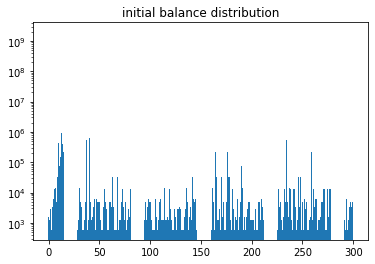

In [63]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])
plt.title("initial balance distribution")
plt.yscale("log")

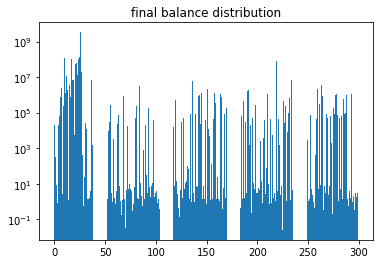

In [64]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])
plt.title("final balance distribution")
plt.yscale("log")

In [65]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]

agent
0      19260.717682
1       -965.722846
2      -2836.399246
3       -581.778892
4      18296.202810
           ...     
295    -1270.575460
296    -3324.102136
297    -4796.895812
298    -3322.726775
299    -4797.059318
Name: balance, Length: 300, dtype: float64

<AxesSubplot:xlabel='agent'>

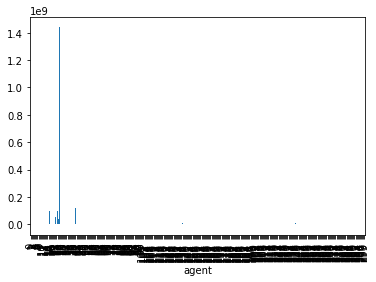

In [66]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]-balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent")["balance"]).plot.bar()

In [67]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent")["balance"]

agent
0      20836.432023
1        306.908486
2          8.977615
3          0.831808
4      21620.654263
           ...     
295        2.055872
296        0.349317
297        3.104188
298        1.724678
299        2.940682
Name: balance, Length: 300, dtype: float64

In [68]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,agent,tick,balance
1027200,0,249952,2.083643e+04
1027201,1,249952,3.069085e+02
1027202,2,249952,8.977615e+00
1027203,3,249952,8.318079e-01
1027204,4,249952,2.162065e+04
1027205,5,249952,6.493319e+04
1027206,6,249952,7.919718e+05
1027207,7,249952,2.488247e+06
1027208,8,249952,2.803656e+00
1027209,9,249952,2.419643e+05


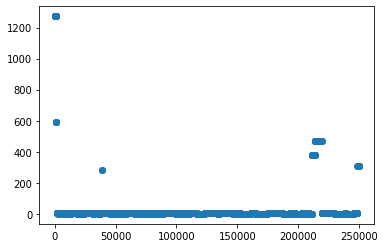

In [69]:
plt.scatter(balance_df[balance_df["agent"] == 1]["tick"],balance_df[balance_df["agent"] == 1]["balance"])

In [70]:
#for agent in balance_df["agent"].unique():
#    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"])


In [71]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].drop("tick", axis=1).set_index("agent") / balance_df[balance_df["tick"] == balance_df["tick"].min()].drop("tick", axis=1).set_index("agent")

,balance
agent,
0,13.223483
1,0.241161
2,0.003155
3,0.001428
4,6.503525
...,...
295,0.001615
296,0.000105
297,0.000647


# Inventory

## Last Tick Inventory

In [72]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,agent,tick,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
1027200,0,249952,9440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027201,1,249952,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027202,2,249952,0.0,0.0,4698.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027203,3,249952,0.0,0.0,0.0,1592.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027204,4,249952,0.0,0.0,0.0,0.0,10949.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027495,295,249952,0.0,971.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027496,296,249952,0.0,0.0,0.0,0.0,11341.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027497,297,249952,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1027498,298,249952,0.0,0.0,0.0,0.0,2020.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Produced Goods Inventory

In [73]:
agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,tick
0,9440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,4698.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,1592.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,10949.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,971.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,11341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1332.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
298,0.0,0.0,0.0,0.0,2020.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


### Input Resources Inventory

In [74]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [75]:
(inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent") - agent_goods_df * inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].set_index("agent")) - (agent_goods_df @ production_chain_df.T)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,tick
agent,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## Production Surplus/Deficit

In [76]:
agent_id = 22
target_tick = np.inf

target_tick = np.clip(target_tick, 0, inventory_df["tick"].max())

#inv_s = inventory_df[inventory_df["tick"] == target_tick].set_index("agent").loc[agent_id].drop("tick")
inv_s = inventory_df.drop("tick", axis=1).groupby("agent").mean().loc[agent_id]
need_s = (agent_goods_df.loc[agent_id] @ production_chain_df.T)
batch_s = (agent_goods_df * production_chain.batch_sizes[np.newaxis,:]).loc[agent_id] @ production_chain_df.T
deficit_df = pd.DataFrame({"inventory":inv_s, "unit_need":need_s, "batch_need": batch_s, "surplus":inv_s - batch_s, "batches":inv_s/batch_s})
deficit_df

,inventory,unit_need,batch_need,surplus,batches
0,0.000000,0.0,0.0,0.000000,NaN
1,0.000000,0.0,0.0,0.000000,NaN
2,0.000000,0.0,0.0,0.000000,NaN
3,0.000000,0.0,0.0,0.000000,NaN
4,0.000000,0.0,0.0,0.000000,NaN
5,0.000000,0.0,0.0,0.000000,NaN
6,0.000000,0.0,0.0,0.000000,NaN
7,0.000000,0.0,0.0,0.000000,NaN
8,0.000000,0.0,0.0,0.000000,NaN
9,0.000000,0.0,0.0,0.000000,NaN


In [77]:
balance_df[(balance_df["agent"] == agent_id) & (balance_df["tick"] == target_tick)]

,agent,tick,balance
1027222,22,249952,6.633875e+07


In [78]:
buy_price_df[(buy_price_df["tick"] == target_tick) & (buy_price_df["agent"] == agent_id)].T

,1027222
agent,22.00000
tick,249952.00000
0,0.00000
1,0.00000
2,0.00000
3,0.00000
4,0.00000
5,0.00000
6,0.00000
7,0.00000


In [79]:
buy_budget_df[(buy_budget_df["tick"] == target_tick) & (buy_budget_df["agent"] == agent_id)].T

,1027222
agent,22.0
tick,249952.0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0


In [80]:
inventory_df[inventory_df["agent"] == agent_id].drop("agent", axis=1).set_index("tick")[agent_id].describe()

count     3425.000000
mean      4576.831825
std       4663.039803
min          0.000000
25%          0.000000
50%       3012.000000
75%       7747.000000
max      16757.000000
Name: 22, dtype: float64

# Buy and Sell Prices

In [81]:
max_last_buy_price = buy_price_df[buy_price_df["tick"] == buy_price_df["tick"].max()].drop(["agent", "tick"], axis=1).max(axis=0)
min_last_sell_price = sell_price_df[sell_price_df["tick"] == sell_price_df["tick"].max()].drop(["agent", "tick"], axis=1).min(axis=0)
#max_last_buy_price - min_last_sell_price
min_last_sell_price

0     7.428566e+00
1     7.736867e+00
2     1.546231e+01
3     1.721541e+00
4     1.255485e+01
5     7.457571e+00
6     7.672187e+00
7     1.547271e+01
8     1.754803e+00
9     1.242982e+01
10    9.675193e+01
11    9.214928e+01
12    7.177698e+01
13    1.821826e+02
14    9.258284e+01
15    1.101514e+02
16    9.265170e+01
17    1.492170e+02
18    1.261958e+02
19    8.968035e+02
20    1.890085e+03
21    2.007580e+03
22    1.593918e+03
23    1.422591e+03
24    2.452236e+04
25    1.211229e+06
26    1.928435e+07
27    1.238758e+05
dtype: float64

## Market Analysis for one Good

### Overview of one Market

In [82]:
product_id = 3
min_ticks = 0
max_ticks = np.inf

max_ticks = np.clip(max_ticks, 0, sell_price_df["tick"].max())

dfsp = sell_price_df[(sell_price_df[product_id] < np.inf) & (sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)
dfms = min_sell_price_df[(min_sell_price_df[product_id] < np.inf) & (min_sell_price_df["tick"].between(min_ticks,max_ticks))][["agent", "tick", product_id]].merge(inventory_df[["agent", "tick", product_id]], on=["tick", "agent"], suffixes=("","_inventory")).rename({str(product_id): product_id}, axis=1)

df1 = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df1_mean = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].mean().to_frame()
df1_max = dfsp[dfsp[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].max().to_frame()
dfms = dfms[dfms[f'{product_id}_inventory'] > 0].groupby("tick")[product_id].min().to_frame()
df2 = buy_price_df[(buy_price_df["tick"].between(min_ticks, max_ticks)) & (buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
df2[product_id] = df2[product_id]
dfmb = max_buy_price_df[(max_buy_price_df["tick"].between(min_ticks, max_ticks)) & (max_buy_price_df[product_id] > 0)][["tick", "agent", product_id]]
dfmb[product_id] = dfmb[product_id]

buyer_df = buy_budget_df[(buy_budget_df[product_id] > 0) & buy_budget_df["tick"].between(min_ticks, max_ticks)][["tick", "agent", product_id]].merge(df2, on=["tick", "agent"], suffixes=["_budget", "_price"])
buyer_df["units"] = buyer_df[f'{product_id}_budget'] / buyer_df[f'{product_id}_price']
seller_df = inventory_df[inventory_df["tick"].between(min_ticks, max_ticks) & inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("tick")[product_id].sum()
seller_df = seller_df.loc[min_ticks:max_ticks]


Seller prices

In [83]:
sell_price_df[(sell_price_df[product_id] < np.inf) & sell_price_df["tick"].between(min_ticks, max_ticks)].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,1.761271,0.183044,1.721541,1.73893,1.73893,1.73893,4.0
28,3425.0,1.740409,0.063141,1.721541,1.73893,1.73893,1.73893,4.0
33,3425.0,1.743441,0.075676,1.721541,1.73893,1.73893,1.73893,4.0
34,3425.0,1.761250,0.183046,1.721541,1.73893,1.73893,1.73893,4.0
38,3425.0,1.739378,0.061387,1.721541,1.73893,1.73893,1.73893,4.0
...,...,...,...,...,...,...,...,...
274,3425.0,1.743355,0.075689,1.721541,1.73893,1.73893,1.73893,4.0
280,3425.0,1.744152,0.077105,1.721541,1.73893,1.73893,1.73893,4.0
284,3425.0,1.749115,0.108829,1.721541,1.73893,1.73893,1.73893,4.0


Buyer Prices

In [84]:
buyer_df.groupby("agent")[f'{product_id}_price'].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,6.0,4.354928,0.456105,4.000000,4.055470,4.103581,4.713786,4.965787
31,21.0,4.191012,0.067383,4.000000,4.224299,4.224299,4.224299,4.224299
36,4.0,4.071195,0.063574,4.000000,4.030000,4.070941,4.112136,4.142900
41,7.0,4.420599,0.449224,4.000000,4.070941,4.105414,4.882516,4.931867
48,913.0,1.874256,0.417967,0.866179,1.734027,1.792576,1.855629,4.145911
49,4.0,4.071195,0.063574,4.000000,4.030000,4.070941,4.112136,4.142900
50,6.0,4.116289,0.090907,4.000000,4.055470,4.110397,4.177840,4.239457
56,7.0,3.942343,0.191409,3.667065,3.826222,4.000000,4.070941,4.135012
60,6.0,3.943132,0.205776,3.681464,3.767151,4.020000,4.086411,4.145911


#### Market Volume

320463.0


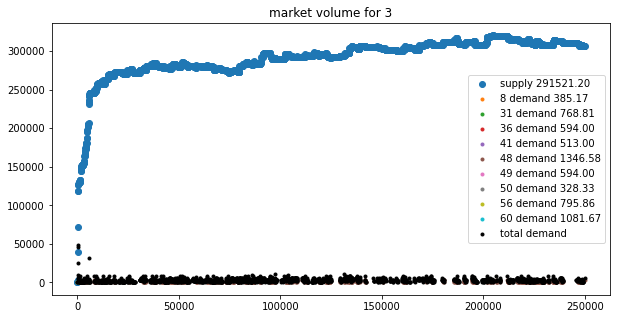

In [85]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(seller_df[seller_df>0].index, seller_df[seller_df>0], label=f'supply {seller_df.mean():.2f}')
for agent_id, color in zip(buyer_df["agent"].unique(), colors[1:]):
    plt.scatter(buyer_df[buyer_df["agent"] == agent_id]["tick"], buyer_df[buyer_df["agent"] == agent_id]["units"], label=f'{agent_id} demand {buyer_df[buyer_df["agent"] == agent_id]["units"].mean():.2f}', marker=".")
total_demand = buyer_df.groupby("tick")["units"].sum()
plt.scatter(total_demand.index, total_demand, label="total demand", marker=".", color="black")
plt.legend(loc="right")
plt.title(f'market volume for {product_id}')
print(seller_df.max())

In [86]:
seller_df[seller_df > 0].index.to_series().describe()

count      3425.0000
mean     124976.0000
std       72186.5364
min           0.0000
25%       62488.0000
50%      124976.0000
75%      187464.0000
max      249952.0000
Name: tick, dtype: float64

In [87]:
seller_df.describe()

count      3425.000000
mean     291521.199124
std       27551.376302
min         690.000000
25%      280410.000000
50%      295957.000000
75%      308232.000000
max      320463.000000
Name: 3, dtype: float64

In [88]:
buyer_df.groupby("agent")["units"].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,6.0,385.166667,587.180182,1.0,3.75,12.0,830.25,1182.0
31,21.0,768.809524,639.294269,12.0,602.00,619.0,659.00,2624.0
36,4.0,594.000000,672.053569,12.0,12.00,591.0,1173.00,1182.0
41,7.0,513.000000,635.250082,1.0,6.50,12.0,1129.00,1307.0
48,913.0,1346.577218,794.561146,12.0,845.00,860.0,2609.00,2628.0
49,4.0,594.000000,672.053569,12.0,12.00,591.0,1173.00,1182.0
50,6.0,328.333333,515.992506,1.0,3.75,12.0,574.50,1182.0
56,7.0,795.857143,981.332840,12.0,30.00,288.0,1321.50,2568.0
60,6.0,1081.666667,1112.015228,12.0,133.25,839.5,1922.25,2618.0


In [89]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id])[0])][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
31,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
36,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
41,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
48,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
49,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
56,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
60,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [90]:
df2[product_id].max()

5.987468230275816

In [91]:
df2.groupby("tick")[product_id].describe().describe()

,count,mean,std,min,25%,50%,75%,max
count,3425.0,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000,3425.000000
mean,41.0,3.865520,0.897619,1.681745,3.677690,4.147275,4.239511,5.291356
std,0.0,0.050966,0.051874,0.213773,0.069963,0.010487,0.034990,0.108792
min,41.0,3.803553,0.000000,0.862470,3.667065,4.000000,4.000000,4.000000
25%,41.0,3.848433,0.879730,1.664099,3.667065,4.145911,4.233916,5.278383
50%,41.0,3.855647,0.904756,1.734478,3.667065,4.145911,4.233916,5.278383
75%,41.0,3.869112,0.920180,1.792576,3.667065,4.145911,4.233916,5.278383
max,41.0,4.272464,1.037529,4.104714,4.145911,4.215878,4.471683,5.987468


#### Market Price

is there a transaction?
do the sellers have inventory?
do any buyers demand goods?
are prices compatible?
is at least one agent in the cannot buy state (> 100 ticks)


Text(0.5, 1.0, 'price chart for 3')

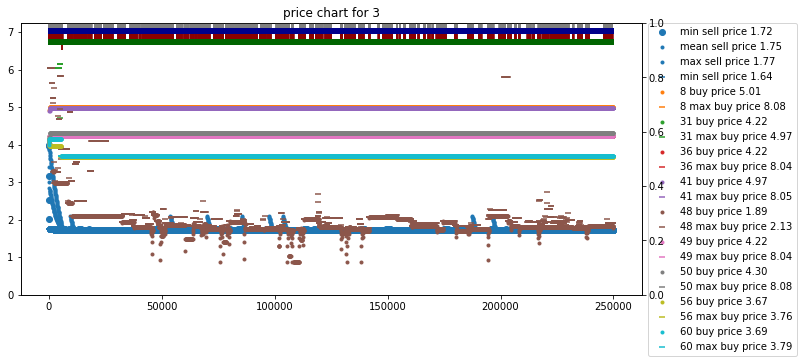

In [92]:
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(15,5))
plt.scatter(df1.index, df1[product_id], label=f'min sell price {df1[product_id].mean():.2f}', color=colors[0])
plt.scatter(df1_mean.index, df1_mean[product_id], label=f'mean sell price {df1_mean[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(df1_mean.index, df1_max[product_id], label=f'max sell price {df1_max[product_id].mean():.2f}', color=colors[0], marker=".")
plt.scatter(dfms.index, dfms[product_id], label=f'min sell price {dfms[product_id].mean():.2f}', marker="_", color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(df2[df2["agent"] == agent]["tick"], df2[df2["agent"] == agent][product_id], label=f'{agent} buy price {df2[df2["agent"] == agent][product_id].mean():.2f}', marker=".", color=color)
    plt.scatter(dfmb[dfmb["agent"] == agent]["tick"], dfmb[dfmb["agent"] == agent][product_id], label=f'{agent} max buy price {dfmb[dfmb["agent"] == agent][product_id].mean():.2f}', marker="_", color=color)
if len(df2) > 0:
    plt.ylim(0, df2[product_id].max()*1.1)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#plt.legend(loc="right")
plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)

# some status indicators
ax2 = plt.twinx()
print("is there a transaction?")
ax2.vlines(transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)]["tick"], ymin=0.98, ymax=1, color="gray")
print("do the sellers have inventory?")
ax2.vlines(seller_df[seller_df>0].index, ymin=0.96, ymax=0.98, color="darkblue")
print("do any buyers demand goods?")
ax2.vlines(buyer_df["tick"].unique()[(buyer_df.groupby("tick")["units"].sum() > 0)], ymin=0.94, ymax=0.96, color="darkred")
print("are prices compatible?")
price_diff = (df2.groupby("tick")[product_id].max() - df1[product_id]).rename("price_diff")
ax2.vlines(df1.join(price_diff[price_diff>0]).index, ymin=0.92, ymax=0.94, color="darkgreen")
print("is at least one agent in the cannot buy state (> 100 ticks)")
ax2.vlines(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)]["tick"].unique()[(cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks)].groupby("tick")[product_id].max() > 100)], ymin=0.90, ymax=0.92, color="darkred")
ax2.set_ylim(0,1)
plt.subplots_adjust(right=0.7)

plt.title(f'price chart for {product_id}')

#plt.tight_layout(rect=[0, 0, 0.75, 1])



In [93]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
190,74,3,109,230,4.000000,10.0,40.000000
214,75,3,86,174,4.000000,10.0,40.000000
233,76,3,50,244,4.000000,10.0,40.000000
252,77,3,220,83,4.000000,10.0,40.000000
266,78,3,299,251,4.000000,10.0,40.000000
...,...,...,...,...,...,...,...
591323,249150,3,228,131,1.730635,821.0,1420.851095
591335,249151,3,228,131,1.730635,55.0,95.184909
591420,249223,3,228,123,1.730635,876.0,1516.036004
591583,249296,3,228,104,1.730635,876.0,1516.036004


#### Ticks when max buy price changes a lot

In [94]:
def consecutive_diffs(x):
    return x.iloc[1] - x.iloc[0]
    print(x)
    raise Exception(x.__class__)
mb_diffs = dfmb.set_index("tick").groupby("agent")[product_id].rolling(2).apply(consecutive_diffs)
mb_diffs.to_frame().sort_values(["agent", product_id], key=abs, ascending=False).groupby("agent").head(5)

3
agent tick          
299   146   0.039963
      292   0.019264
      73    0.000000
      219   0.000000
      365   0.000000
...              ...
8     219   0.043421
      146   0.040000
      73    0.000000
      292   0.000000
      365   0.000000

[205 rows x 1 columns]

#### Balance

(0.0, 303910.96169827285)

<Figure size 432x288 with 0 Axes>

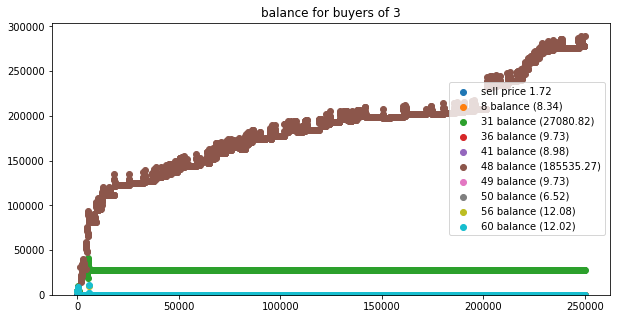

In [95]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(df2["agent"].unique(), colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for buyers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

In [96]:
np.where(agent_goods_df[product_id])

(array([  3,  28,  33,  34,  38,  46,  52,  53,  58,  59,  65,  66,  67,
         69,  77,  83,  87,  91, 102, 103, 104, 107, 122, 123, 126, 131,
        132, 133, 138, 146, 150, 152, 153, 154, 155, 156, 160, 163, 169,
        173, 174, 180, 183, 187, 192, 194, 203, 205, 206, 214, 215, 216,
        218, 222, 225, 230, 240, 244, 249, 251, 255, 256, 265, 273, 274,
        280, 284, 292, 294]),)

(0.0, 9562.058677368623)

<Figure size 432x288 with 0 Axes>

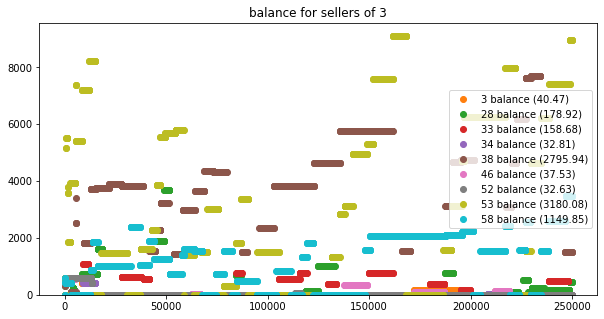

In [97]:
plt.subplots_adjust(right=0.7)
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
plt.figure(figsize=(10,5))
#plt.scatter(df1.index, df1[product_id], label=f'sell price {df1[product_id].mean():.2f}', color=colors[0])
for agent, color in zip(np.where(agent_goods_df[product_id])[0], colors[1:]):
    plt.scatter(balance_df[balance_df["agent"] == agent]["tick"], balance_df[balance_df["agent"] == agent]["balance"], color=color, label=f'{agent} balance ({balance_df[balance_df["agent"] == agent]["balance"].mean():.2f})')
plt.title(f'balance for sellers of {product_id}')
plt.legend(loc="right")
plt.ylim(0)

### Sellers for the Market

In [98]:
np.where(agent_goods_df[product_id] == 1)

(array([  3,  28,  33,  34,  38,  46,  52,  53,  58,  59,  65,  66,  67,
         69,  77,  83,  87,  91, 102, 103, 104, 107, 122, 123, 126, 131,
        132, 133, 138, 146, 150, 152, 153, 154, 155, 156, 160, 163, 169,
        173, 174, 180, 183, 187, 192, 194, 203, 205, 206, 214, 215, 216,
        218, 222, 225, 230, 240, 244, 249, 251, 255, 256, 265, 273, 274,
        280, 284, 292, 294]),)

Amounts Sold

In [99]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["amount"].sum()

seller
3      43858.0
28     79418.0
33     75152.0
34     24080.0
38     78628.0
        ...   
274    71295.0
280    63133.0
284    58441.0
292    57130.0
294    39900.0
Name: amount, Length: 69, dtype: float64

Time ranges of sales

In [100]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
3,70.0,118054.571429,83154.521398,8546.0,49933.25,99026.5,216300.25,248422.0
28,74.0,97649.081081,79714.747416,98.0,28544.00,85557.0,151695.00,248713.0
33,73.0,106716.739726,80019.783985,96.0,38765.00,87163.0,187030.00,248128.0
34,58.0,119164.551724,82865.448323,9058.0,46337.75,87747.0,206756.75,248713.0
38,71.0,89807.154930,87922.946799,98.0,5439.50,58109.0,178887.50,246449.0
...,...,...,...,...,...,...,...,...
274,65.0,109616.707692,85586.324133,85.0,38765.00,88039.0,201627.00,248639.0
280,52.0,94962.826923,75633.404300,102.0,29967.50,80156.0,158686.25,246303.0
284,61.0,116586.655738,83579.794674,88.0,43802.00,119210.0,190754.00,249369.0


Prices for transactions

In [101]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("seller")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
seller,,,,,,,,
3,70.0,1.800188,0.114859,1.721547,1.748331,1.770439,1.810840,2.403469
28,74.0,2.034128,0.596232,1.721547,1.735152,1.775280,1.841685,4.000000
33,73.0,1.981785,0.556074,1.721547,1.732307,1.765436,1.834012,4.000000
34,58.0,1.768404,0.036254,1.721919,1.742403,1.760731,1.778436,1.885611
38,71.0,2.107278,0.574015,1.721919,1.752786,1.778574,2.378435,4.000000
...,...,...,...,...,...,...,...,...
274,65.0,1.996793,0.589539,1.721547,1.741263,1.769010,1.818766,4.000000
280,52.0,1.977804,0.551579,1.721547,1.730505,1.759497,1.786331,4.000000
284,61.0,1.998441,0.557325,1.721853,1.743455,1.765436,1.858444,4.000000


Desired sell prices

In [102]:
sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,1.761271,0.183044,1.721541,1.73893,1.73893,1.73893,4.0
28,3425.0,1.740409,0.063141,1.721541,1.73893,1.73893,1.73893,4.0
33,3425.0,1.743441,0.075676,1.721541,1.73893,1.73893,1.73893,4.0
34,3425.0,1.761250,0.183046,1.721541,1.73893,1.73893,1.73893,4.0
38,3425.0,1.739378,0.061387,1.721541,1.73893,1.73893,1.73893,4.0
...,...,...,...,...,...,...,...,...
274,3425.0,1.743355,0.075689,1.721541,1.73893,1.73893,1.73893,4.0
280,3425.0,1.744152,0.077105,1.721541,1.73893,1.73893,1.73893,4.0
284,3425.0,1.749115,0.108829,1.721541,1.73893,1.73893,1.73893,4.0


Min Sell Prices

In [103]:
min_sell_price_df[sell_price_df[product_id] < np.inf][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,1.729212,0.030327,1.634594,1.73893,1.73893,1.73893,1.73893
28,3425.0,1.729669,0.029677,1.634594,1.73893,1.73893,1.73893,1.73893
33,3425.0,1.730187,0.028914,1.634594,1.73893,1.73893,1.73893,1.73893
34,3425.0,1.729182,0.030370,1.634594,1.73893,1.73893,1.73893,1.73893
38,3425.0,1.729121,0.030455,1.634594,1.73893,1.73893,1.73893,1.73893
...,...,...,...,...,...,...,...,...
274,3425.0,1.729730,0.029589,1.634594,1.73893,1.73893,1.73893,1.73893
280,3425.0,1.728938,0.030707,1.634594,1.73893,1.73893,1.73893,1.73893
284,3425.0,1.729395,0.030070,1.634594,1.73893,1.73893,1.73893,1.73893


Product inventory

In [104]:
inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,1017.129927,311.519046,10.0,898.0,1042.0,1130.0,1592.0
28,3425.0,8169.434161,800.163728,10.0,8148.0,8206.0,8598.0,8759.0
33,3425.0,6280.021606,566.230721,10.0,6133.0,6235.0,6588.0,7001.0
34,3425.0,504.504526,148.494810,10.0,478.0,542.0,550.0,732.0
38,3425.0,9946.863942,1625.610537,10.0,8759.0,9361.0,11409.0,13184.0
...,...,...,...,...,...,...,...,...
274,3425.0,4604.150365,628.701667,10.0,4629.0,4650.0,4675.0,5239.0
280,3425.0,6105.869489,690.316737,10.0,6177.0,6279.0,6303.0,6357.0
284,3425.0,4430.215182,473.019199,10.0,4111.0,4312.0,4595.0,5271.0


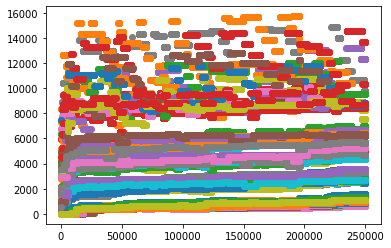

In [105]:
for agent in np.where(agent_goods_df[product_id])[0]:
    plt.scatter(inventory_df[inventory_df["agent"] == agent]["tick"], inventory_df[inventory_df["agent"] == agent][product_id])

Input inventory

In [106]:
production_needs = pd.Series(production_chain.adj_matrix[:,product_id] * production_chain.batch_sizes[product_id])
production_needs[production_needs > 0].to_frame()

,0


In [107]:
production_needs[production_needs > 0].index.to_list()

[]

In [108]:
input_ids = production_needs[production_needs > 0].index.to_list()
inventory_melt = pd.melt(inventory_df[inventory_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["agent", "tick"]+input_ids], id_vars=["agent", "tick"], value_vars=input_ids, var_name="product")
input_inventory_info = inventory_melt.groupby(["agent", "product"])["value"].describe()
input_inventory_info

,count,mean,std,min,25%,50%,75%,max


In [109]:
inventory_melt.groupby(["agent","tick"])["value"].min().groupby("agent").describe()

,count,mean,std,min,25%,50%,75%,max


Cannot sell ticks by seller

In [110]:
relevant_cannot_sell_df = cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[product_id])[0])][["tick", "agent", product_id]]
relevant_cannot_sell_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
3,3425.0,600.774015,676.242858,0.0,146.0,365.0,876.0,2628.0
28,3425.0,651.138686,691.948540,0.0,146.0,365.0,1022.0,2555.0
33,3425.0,680.530511,702.424110,0.0,146.0,365.0,1095.0,2555.0
34,3425.0,605.420438,677.617683,0.0,146.0,365.0,876.0,2628.0
38,3425.0,626.116204,683.273972,0.0,146.0,365.0,949.0,2555.0
...,...,...,...,...,...,...,...,...
274,3425.0,653.440584,693.370785,0.0,146.0,365.0,1022.0,2555.0
280,3425.0,581.612847,655.302074,0.0,146.0,292.0,803.0,2482.0
284,3425.0,619.700730,678.237240,0.0,146.0,365.0,949.0,2555.0


Text(0.5, 1.0, 'cannot sell 3')

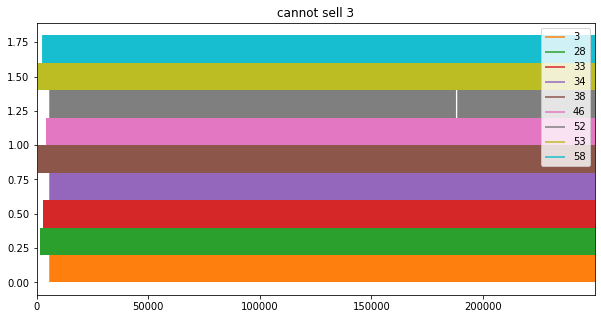

In [111]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_sell_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_sell_df[(relevant_cannot_sell_df["agent"] == agent) & (relevant_cannot_sell_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.xlim(min_ticks, max_ticks)
plt.title(f'cannot sell {product_id}')

### Buyers for the Market

Total Amount Purchased

In [112]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["amount"].sum()

buyer
8        1490.0
31      21486.0
36       1463.0
41       3307.0
48     859798.0
49       1463.0
50       1479.0
56       6862.0
60       8491.0
61       1413.0
72      24015.0
76       1463.0
82       1500.0
86      10398.0
92       1422.0
93     699376.0
95       1521.0
99       3225.0
100      7428.0
109      2060.0
137      1345.0
144     18577.0
148      7843.0
162      1488.0
172      1444.0
175      8498.0
189      6083.0
197     13022.0
198    987268.0
207     28451.0
208      8046.0
220      3600.0
228    966028.0
233     12133.0
235      2634.0
250      5096.0
254      7343.0
269     32443.0
270      3070.0
297      1345.0
299      3657.0
Name: amount, dtype: float64

Time Ranges of Purchase

In [113]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
8,7.0,189.285714,97.258615,86.0,124.50,155.0,234.50,366.0
31,25.0,2666.000000,2456.655789,79.0,304.00,731.0,5111.00,5549.0
36,4.0,160.500000,69.294059,99.0,101.25,161.0,220.25,221.0
41,10.0,227.300000,101.963011,90.0,175.50,231.5,279.50,439.0
48,975.0,121443.487179,79777.367494,101.0,49679.00,106145.0,212431.50,248785.0
49,3.0,140.000000,70.292247,95.0,99.50,104.0,162.50,221.0
50,9.0,183.555556,84.569662,76.0,150.00,164.0,209.00,366.0
56,9.0,1988.666667,2709.078672,91.0,182.00,223.0,5551.00,5695.0
60,11.0,1183.454545,2196.236388,103.0,163.50,210.0,308.50,5695.0


Prices Paid

In [114]:
transaction_df[(transaction_df["product"] == product_id) & transaction_df["tick"].between(min_ticks, max_ticks)].groupby("buyer")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
buyer,,,,,,,,
8,7.0,3.608846,0.300055,3.319840,3.336100,3.634941,3.817470,4.0
31,25.0,3.136748,0.320899,2.972920,2.981614,2.981614,3.093279,4.0
36,4.0,3.669325,0.381831,3.338650,3.338650,3.669325,4.000000,4.0
41,10.0,3.547452,0.267164,3.319907,3.323780,3.454758,3.634941,4.0
48,975.0,1.833143,0.216946,1.722007,1.746323,1.765436,1.824828,4.0
49,3.0,3.779550,0.381831,3.338650,3.669325,4.000000,4.000000,4.0
50,9.0,3.610061,0.310845,2.989193,3.634941,3.634941,3.634941,4.0
56,9.0,3.303051,0.541720,2.702998,2.710427,3.334706,3.634941,4.0
60,11.0,3.433869,0.461060,2.710197,3.086715,3.634941,3.634941,4.0


Desired Buy Prices

In [115]:
buy_price_df[buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,3425.0,5.005604,0.032357,4.000000,5.006746,5.006746,5.006746,5.006746
31,3425.0,4.224095,0.005769,4.000000,4.224299,4.224299,4.224299,4.224299
36,3425.0,4.215709,0.005288,4.000000,4.215878,4.215878,4.215878,4.215878
41,3425.0,4.972261,0.031258,4.000000,4.973391,4.973391,4.973391,4.973391
48,3425.0,1.886995,0.340194,0.866179,1.747981,1.816480,2.005568,4.145911
49,3425.0,4.215709,0.005288,4.000000,4.215878,4.215878,4.215878,4.215878
50,3425.0,4.295338,0.008267,4.000000,4.295652,4.295652,4.295652,4.295652
56,3425.0,3.673576,0.043403,3.667065,3.667065,3.667065,3.667065,4.135012
60,3425.0,3.691686,0.067921,3.681464,3.681464,3.681464,3.681464,4.145911


In [116]:
max_buy_price_df[max_buy_price_df[product_id] > 0][["agent", "tick", product_id]].groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,3425.0,8.083359,0.002147,8.000000,8.083421,8.083421,8.083421,8.083421
31,3425.0,4.967512,0.201256,4.703716,4.941054,4.941054,4.941054,8.047336
36,3425.0,8.039958,0.000966,8.000000,8.039982,8.039982,8.039982,8.039982
41,3425.0,8.047338,0.001158,8.000000,8.047370,8.047370,8.047370,8.047370
48,3425.0,2.130532,0.720046,1.728186,1.824411,1.934837,2.081145,8.059227
49,3425.0,8.039958,0.000966,8.000000,8.039982,8.039982,8.039982,8.039982
50,3425.0,8.083419,0.002149,8.000000,8.083480,8.083480,8.083480,8.083480
56,3425.0,3.764485,0.646759,3.667065,3.667065,3.667065,3.667065,8.059228
60,3425.0,3.786396,0.643076,3.689535,3.689535,3.689535,3.689535,8.056559


Cannot buy ticks by buyer

In [117]:
relevant_cannot_buy_df = cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & cannot_buy_df["agent"].isin(np.where(production_goods[product_id]>0)[0])][["tick", "agent", product_id]]
relevant_cannot_buy_df.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
31,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
36,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
41,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
48,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
49,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
56,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
60,3425.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Behavior of one buyer

In [118]:
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
price_diff[price_diff > 0].index

Int64Index([], dtype='int64', name='tick')

is transaction?
cannot buy?
has budget?
buy price at max price?
price compatible


Text(0.5, 1.0, 'behavior for buyer 8')

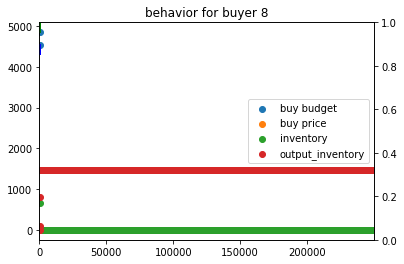

In [119]:
agent_id = relevant_cannot_buy_df["agent"].unique()[0]
agent_output = agent_goods_df.loc[agent_id].idxmax()
plt.scatter(buy_budget_df[buy_budget_df["agent"] == agent_id]["tick"], buy_budget_df[buy_budget_df["agent"] == agent_id][product_id], label=f'buy budget')
plt.scatter(buy_price_df[buy_price_df["agent"] == agent_id]["tick"], buy_price_df[buy_price_df["agent"] == agent_id][product_id], label=f'buy price')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][product_id], label=f'inventory')
plt.scatter(inventory_df[inventory_df["agent"] == agent_id]["tick"], inventory_df[inventory_df["agent"] == agent_id][agent_output], label=f'output_inventory')
plt.legend(loc="right")
ax2 = plt.twinx()

print("is transaction?")
ax2.vlines(transaction_df[(transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]["tick"], ymin=0.95, ymax=1.0, color="green")
print("cannot buy?")
ax2.vlines(cannot_buy_df[(cannot_buy_df["agent"] == agent_id) & (cannot_buy_df[product_id] > 0)]["tick"], ymin=0.90, ymax=0.95, color="red")
print("has budget?")
ax2.vlines(buy_budget_df[(buy_budget_df["agent"] == agent_id) & (buy_budget_df[product_id] > 0)]["tick"], ymin=0.85, ymax=0.90, color="blue")
print("buy price at max price?")
ax2.vlines(buy_price_df[(buy_price_df["agent"] == agent_id) & (max_buy_price_df[product_id] - buy_price_df[product_id] < econ_sim.PRICE_EPS)]["tick"], ymin=0.80, ymax=0.85, color="purple")
price_diff = (buy_price_df[buy_price_df["agent"] == agent].set_index("tick")[product_id] - sell_price_df.groupby("tick")[product_id].min())
print("price compatible")
ax2.vlines(price_diff[price_diff > 0].index, ymin=0.75, ymax=0.80, color="yellow")
ax2.set_ylim(0,1)

plt.xlim(min_ticks, max_ticks)

plt.title(f'behavior for buyer {agent_id}')

In [120]:
transaction_df[transaction_df["tick"].between(min_ticks, max_ticks) & (transaction_df["buyer"] == agent_id) & (transaction_df["product"] == product_id)]

,tick,product,buyer,seller,price,amount,value
382,86,3,8,65,4.000000,10.0,40.000000
484,100,3,8,138,4.000000,2.0,8.000000
592,149,3,8,218,3.634941,19.0,69.063871
685,155,3,8,174,3.634941,95.0,345.319356
1465,234,3,8,249,3.319840,465.0,1543.725807
1475,235,3,8,59,3.319840,898.0,2981.216720
2371,366,3,8,28,3.352359,1.0,3.352359


<AxesSubplot:xlabel='tick'>

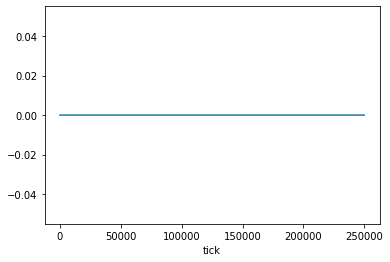

In [121]:
cannot_buy_df[cannot_buy_df["tick"].between(min_ticks, max_ticks) & (cannot_buy_df["agent"] == agent_id)].set_index("tick")[product_id].plot()

When cannot buy exceeds 0

In [122]:
relevant_cannot_buy_df[relevant_cannot_buy_df[product_id] > 0].groupby("agent")["tick"].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
148,2.0,5876.5,51.618795,5840.0,5858.25,5876.5,5894.75,5913.0
197,1.0,6205.0,NaN,6205.0,6205.00,6205.0,6205.00,6205.0
198,1.0,120596.0,NaN,120596.0,120596.00,120596.0,120596.00,120596.0
250,2.0,5803.5,51.618795,5767.0,5785.25,5803.5,5821.75,5840.0


(0.0, 249952.0)

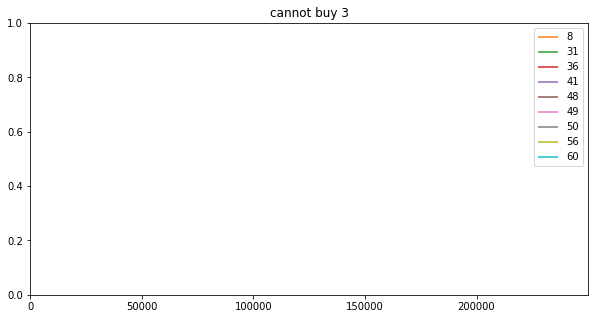

In [123]:
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()["color"]
vtick = 0
vtick_step = 0.2
for agent, color in zip(relevant_cannot_buy_df["agent"].unique(), colors[1:]):
    plt.vlines(relevant_cannot_buy_df[(relevant_cannot_buy_df["agent"] == agent) & (relevant_cannot_buy_df[product_id]>100)]["tick"], ymin=vtick, ymax=vtick+vtick_step, label=f'{agent}', color=color)
    vtick += vtick_step
plt.legend()
plt.title(f'cannot buy {product_id}')
plt.xlim(min_ticks, max_ticks)

## Buy/Sell Price Investigation

In [124]:
df1[product_id].describe()

count    3425.000000
mean        1.724817
std         0.061816
min         1.721541
25%         1.721541
50%         1.721541
75%         1.721541
max         4.000000
Name: 3, dtype: float64

In [125]:
df2.groupby("agent")[product_id].describe()

,count,mean,std,min,25%,50%,75%,max
agent,,,,,,,,
8,3425.0,5.005604,0.032357,4.000000,5.006746,5.006746,5.006746,5.006746
31,3425.0,4.224095,0.005769,4.000000,4.224299,4.224299,4.224299,4.224299
36,3425.0,4.215709,0.005288,4.000000,4.215878,4.215878,4.215878,4.215878
41,3425.0,4.972261,0.031258,4.000000,4.973391,4.973391,4.973391,4.973391
48,3425.0,1.886995,0.340194,0.866179,1.747981,1.816480,2.005568,4.145911
49,3425.0,4.215709,0.005288,4.000000,4.215878,4.215878,4.215878,4.215878
50,3425.0,4.295338,0.008267,4.000000,4.295652,4.295652,4.295652,4.295652
56,3425.0,3.673576,0.043403,3.667065,3.667065,3.667065,3.667065,4.135012
60,3425.0,3.691686,0.067921,3.681464,3.681464,3.681464,3.681464,4.145911


In [126]:
df2[df2["tick"] == df2["tick"].max()][product_id].max() - df1[product_id].iloc[-1]

3.5568425177031084

In [127]:
(df2.groupby("tick")[product_id].max() - df1[product_id]).describe()

count    3425.000000
mean        3.566539
std         0.142194
min         0.000000
25%         3.556843
50%         3.556843
75%         3.556843
max         4.265927
Name: 3, dtype: float64

In [128]:
dfmb[dfmb["tick"] == dfmb["tick"].max()][product_id].max() - dfms[product_id].iloc[-1]

6.448949730651491

In [129]:
(dfmb.groupby("tick")[product_id].max() - dfms[product_id]).describe()

count    3425.000000
mean        6.441486
std         0.027098
min         6.261070
25%         6.448950
50%         6.448950
75%         6.448950
max         6.448950
Name: 3, dtype: float64

In [130]:
bp_s = (production_goods.loc[product_id] * buy_price_df[buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
mbp_s = (production_goods.loc[product_id] * max_buy_price_df[max_buy_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1)).sum(axis=1)
sp_s = sell_price_df[sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
msp_s = min_sell_price_df[min_sell_price_df["agent"] == product_id].drop(["agent", "tick"], axis=1).min(axis=1)
price_df = pd.DataFrame({"cost":bp_s, "max_cost":mbp_s, "price":sp_s, "min_price":msp_s, "unit_profit":sp_s-bp_s})
price_df

,cost,max_cost,price,min_price,unit_profit
3,0.0,0.0,4.000000,1.73893,4.000000
303,0.0,0.0,3.960000,1.73893,3.960000
603,0.0,0.0,3.920400,1.73893,3.920400
903,0.0,0.0,3.881196,1.73893,3.881196
1203,0.0,0.0,3.842384,1.73893,3.842384
...,...,...,...,...,...
1026003,0.0,0.0,1.738930,1.73893,1.738930
1026303,0.0,0.0,1.738930,1.73893,1.738930
1026603,0.0,0.0,1.738930,1.73893,1.738930
1026903,0.0,0.0,1.738930,1.73893,1.738930


## Larger Scale Market Analysis

In [131]:
demand_units_df = (buy_budget_df.set_index(["agent", "tick"]) / buy_price_df.set_index(["agent", "tick"])).fillna(0.)
supply_units_df = (inventory_df.drop("tick", axis=1).set_index("agent") * agent_goods_df).rename_axis('agent').reset_index(level=0)
supply_units_df["tick"] = inventory_df["tick"]

### Supply Deficit

For each product, on average how many units of supply above demand are on the market

In [132]:
transaction_df.groupby("product")["amount"].sum() / transaction_df["tick"].max()

product
-1     106.385208
 0      20.483756
 1      30.403072
 2      18.893352
 3      15.137556
 4      18.123832
 5      20.310076
 6      29.972080
 7      18.759784
 8      14.627192
 9      17.827308
 10      2.755296
 11      0.553752
 12      0.823788
 13      0.292840
 14      0.280100
 15      1.051560
 16      0.169804
 17      1.570032
 18      1.274976
 19      0.199544
 20      0.023296
 21      0.157352
 22      0.337116
 23      0.198788
 24      0.037752
 25      0.000212
 26      0.000280
 27      0.011648
Name: amount, dtype: float64

In [133]:
demand_units_mean = demand_units_df.groupby("tick").sum().mean()
supply_units_mean = supply_units_df.groupby("tick").sum().mean().drop("agent")
surplus_df = pd.DataFrame({
    "agents": agent_goods_df.sum(axis=0),
    "supply": supply_units_mean,
    "supply_cv": ((supply_units_df.groupby("tick").sum()).std()/(supply_units_df.groupby("tick").sum()).mean()).drop("agent"),
    "demand": demand_units_mean,
    "demand_cv": (demand_units_df.groupby("tick").sum()).std()/(demand_units_df.groupby("tick").sum()).mean(),
    "surplus": supply_units_mean - demand_units_mean
})
surplus_df["min_input_surplus"] = 1./(pd.DataFrame(production_chain.adj_matrix).replace(0, np.nan).multiply(1./surplus_df["surplus"], axis=0).max(axis=0).fillna(np.inf))
surplus_df

,agents,supply,supply_cv,demand,demand_cv,surplus,min_input_surplus
0,26.0,234489.870365,3.355721,1556.170511,1.290075,232933.699854,0.000000
1,47.0,58109.262482,2.605181,2777.519708,1.306533,55331.742774,0.000000
2,17.0,81381.384234,4.464935,1505.793285,0.991208,79875.590949,0.000000
3,69.0,291521.199124,2.570428,1604.500438,1.459145,289916.698686,0.000000
4,18.0,158252.717664,4.671806,1918.618978,1.555707,156334.098686,0.000000
5,18.0,48099.085839,4.000229,19984.594161,1.703587,28114.491679,232933.699854
6,20.0,108090.731387,3.825569,-8573.729635,-5.636254,116664.461022,55331.742774
7,8.0,27304.350365,6.175710,32832.856058,1.007867,-5528.505693,79875.590949
8,41.0,133577.155912,2.854443,19730.286715,1.054612,113846.869197,289916.698686
9,10.0,66819.088175,5.398094,4763.008467,6.080776,62056.079708,156334.098686


In [134]:
surplus_df["surplus"] + surplus_df["min_input_surplus"]

0     232933.699854
1      55331.742774
2      79875.590949
3     289916.698686
4     156334.098686
5     261048.191533
6     171996.203796
7      74347.085255
8     403763.567883
9     218390.178394
10    -16242.195401
11     13545.392863
12      6388.566642
13     18167.189343
14     13619.821285
15    -11510.393827
16     12660.702725
17     -7254.160701
18    -18696.532805
19     13261.815474
20      2258.484964
21     -1578.170657
22     -1353.303066
23     -1193.069489
24      2950.180438
25        24.456717
26         3.067495
27       572.314161
dtype: float64

## Cannot Buy or Sell

In [135]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1)

agent
0      0
1      0
2      0
3      0
4      0
      ..
295    0
296    0
297    0
298    0
299    0
Length: 300, dtype: int64

Text(0.5, 1.0, 'distribution of max cannot buy ticks for agents')

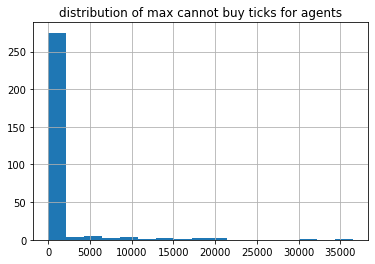

In [136]:
cannot_buy_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_buy_df["agent"].nunique())))
plt.title("distribution of max cannot buy ticks for agents")

Summary of cannot buy by good

In [137]:
maxes = cannot_buy_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][production_goods[product] > 0].describe())
cannot_buy_summary = pd.concat(describe_series, axis=1).T
cannot_buy_summary["cv"] = cannot_buy_summary["std"] / cannot_buy_summary["mean"]
cannot_buy_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_buy_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_buy_summary

,count,mean,std,min,25%,50%,75%,max,cv,min_tick,max_tick
0,18.0,178.444444,203.758283,0.0,0.00,73.0,438.00,438.0,1.141858,74,249953
1,20.0,215.350000,174.807345,0.0,73.00,146.0,438.00,438.0,0.811736,74,249956
2,8.0,118.625000,160.588149,0.0,0.00,73.0,127.75,438.0,1.353746,74,249953
3,41.0,10.682927,34.860751,0.0,0.00,0.0,0.00,146.0,3.263221,74,249953
4,10.0,284.700000,246.836451,0.0,0.00,438.0,492.75,511.0,0.867005,74,248420
5,8.0,16169.500000,12044.968398,4307.0,6716.00,13103.5,21316.00,36500.0,0.744919,75,249955
6,6.0,5961.666667,2980.570124,3066.0,3887.25,4818.0,8103.00,10293.0,0.499956,81,249881
7,6.0,7409.500000,4560.426329,2482.0,3485.75,7117.5,10749.25,13505.0,0.615484,75,249299
8,8.0,10229.125000,7274.346263,0.0,5383.75,9745.5,17520.00,18469.0,0.711141,85,250000
9,9.0,10439.000000,8666.271488,0.0,2336.00,13505.0,16863.00,21243.0,0.830182,80,248055


Text(0.5, 1.0, 'distribution of max cannot sell ticks for agents')

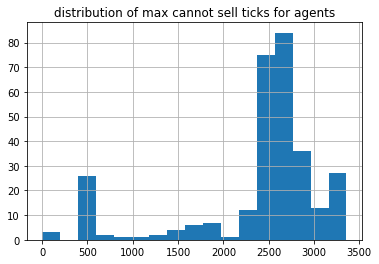

In [138]:
cannot_sell_df.drop("tick", axis=1).groupby("agent").max().max(axis=1).hist(bins=int(np.sqrt(cannot_sell_df["agent"].nunique())))
plt.title("distribution of max cannot sell ticks for agents")

<AxesSubplot:xlabel='tick'>

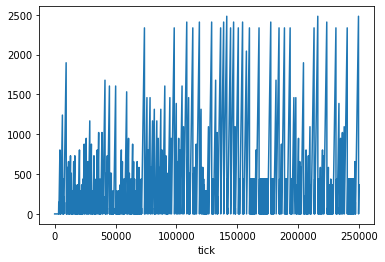

In [139]:
#cannot_sell_df[cannot_sell_df["agent"].isin(np.where(agent_goods_df[0] > 0)[0])]
cannot_sell_df[cannot_sell_df["agent"].isin([0])].set_index("tick")[0].plot()

In [140]:
transaction_df[(transaction_df["product"] == 0) & (transaction_df["seller"] == 0)].groupby("tick")["tick"].count()

tick
2921      1
2923      1
2997      1
3147      1
3363      1
         ..
245865    2
246595    1
246887    2
249515    7
249953    1
Name: tick, Length: 303, dtype: int64

In [141]:
cannot_sell_df[(cannot_sell_df["agent"] == 0) & (cannot_sell_df["tick"] > 46026)]

,agent,tick,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
189300,0,46063,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189600,0,46136,146,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189900,0,46209,219,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190200,0,46282,292,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190500,0,46355,365,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026000,0,249660,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1026300,0,249733,146,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1026600,0,249806,219,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1026900,0,249879,292,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Summary of cannot sell by product

In [142]:
maxes = cannot_sell_df.drop("tick", axis=1).groupby("agent").max()
describe_series = []
for product in agent_goods_df.columns:
    describe_series.append(maxes[product][agent_goods_df[product] > 0].describe())
cannot_sell_summary = pd.concat(describe_series, axis=1).T
cannot_sell_summary["cv"] = cannot_sell_summary["std"] / cannot_sell_summary["mean"]
cannot_sell_summary["min_tick"] = transaction_df.groupby("product")["tick"].min()
cannot_sell_summary["max_tick"] = transaction_df.groupby("product")["tick"].max()
cannot_sell_summary

,count,mean,std,min,25%,50%,75%,max,cv,min_tick,max_tick
0,26.0,2630.807692,88.762163,2482.0,2555.0,2701.0,2701.00,2701.0,0.033740,74,249953
1,47.0,2761.574468,91.733249,2555.0,2701.0,2774.0,2774.00,3066.0,0.033218,74,249956
2,17.0,2524.941176,45.139327,2482.0,2482.0,2555.0,2555.00,2628.0,0.017877,74,249953
3,69.0,2597.318841,76.568979,2482.0,2555.0,2555.0,2628.00,2774.0,0.029480,74,249953
4,18.0,2656.388889,87.237431,2482.0,2628.0,2664.5,2701.00,2847.0,0.032841,74,248420
5,18.0,2668.555556,853.974185,438.0,2445.5,3102.5,3212.00,3285.0,0.320014,75,249955
6,20.0,2996.650000,363.440616,2336.0,2737.5,3212.0,3230.25,3358.0,0.121282,81,249881
7,8.0,2837.875000,980.514506,438.0,3066.0,3212.0,3285.00,3285.0,0.345510,75,249299
8,41.0,1148.414634,908.406379,438.0,438.0,438.0,1752.00,3212.0,0.791009,85,250000
9,10.0,2715.600000,626.837246,1387.0,2336.0,3029.5,3212.00,3212.0,0.230828,80,248055


# Profit Analysis

## Basic Profit = Revenue - Cost

Sum up all revenue (from transactions, final goods are sunk elsewhere)
Sum up all costs (from transactions, basic resources are sourced elsewhere)
Account for inventory (using latest market prices)

profit = costs - revenue + value_of_goods_on_hand

In [143]:
revenue = transaction_df.groupby("seller")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)
costs = transaction_df.groupby("buyer")["value"].sum().reindex(list(range(agent_goods_df.shape[0])), fill_value=0)

In [144]:
costs.describe()

count    3.000000e+02
mean     8.242904e+06
std      4.248472e+07
min      4.892381e+03
25%      1.103625e+05
50%      1.295902e+06
75%      3.305988e+06
max      5.299610e+08
Name: value, dtype: float64

In [145]:
revenue.describe()

count    3.000000e+02
mean     1.550170e+07
std      1.193698e+08
min      9.648000e+01
25%      1.158685e+05
50%      1.396194e+06
75%      3.521698e+06
max      1.968663e+09
Name: value, dtype: float64

Profit (without accounting for inventory value):

In [146]:
(revenue-costs).describe()

count    3.000000e+02
mean     7.258793e+06
std      8.411677e+07
min     -4.160543e+06
25%     -1.349065e+03
50%     -5.986322e+02
75%      8.297121e+04
max      1.438702e+09
Name: value, dtype: float64

<AxesSubplot:>

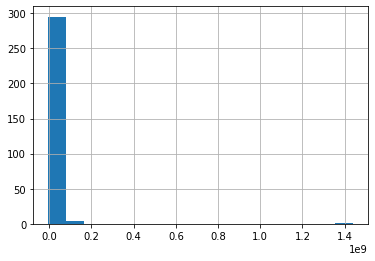

In [147]:
((revenue - costs)).hist(bins=int(np.sqrt(revenue.shape[0])))

How much value is sitting in inventory?

In [148]:
# estimate based on last price in the market
value_of_goods_on_hand = (inventory_df[inventory_df["tick"] == inventory_df["tick"].max()].drop("tick", axis=1).set_index("agent") * transaction_df.groupby("product")["price"].nth(-1)).fillna(0).sum(axis=1)
value_of_goods_on_hand.describe()

count    3.000000e+02
mean     6.196742e+05
std      7.161742e+06
min      0.000000e+00
25%      6.125802e+03
50%      1.528667e+04
75%      6.587013e+04
max      1.223030e+08
dtype: float64

In [149]:
revenue.mean() - costs.mean()

7258792.652618905

In [150]:
value_of_goods_on_hand.mean()/revenue.mean()

0.0399746071674972

Profit (accounting for value of goods on hand):

In [151]:
((revenue - costs) + value_of_goods_on_hand).describe()

count    3.000000e+02
mean     7.878467e+06
std      8.496552e+07
min     -1.308536e+06
25%      4.933032e+03
50%      2.508300e+04
75%      1.742531e+05
max      1.440071e+09
dtype: float64

<AxesSubplot:>

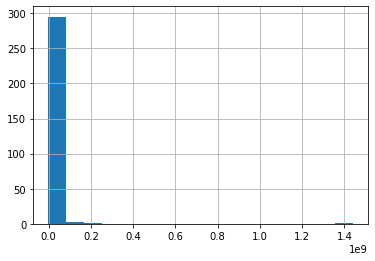

In [152]:
((revenue - costs) + value_of_goods_on_hand).hist(bins=int(np.sqrt(revenue.shape[0])))

## Further Investigation

### Profit by Product

In [153]:
revenue-costs

seller
0      22447.701977
1      -1043.091514
2      -2991.022385
3       -599.168192
4      18170.654263
           ...     
295    -1347.944128
296    -3449.650683
297    -4796.895812
298    -3448.275322
299    -4797.059318
Name: value, Length: 300, dtype: float64

In [154]:
agent_results = pd.DataFrame({"product":agent_goods_df.idxmax(axis=1), "profit":revenue-costs})
profit_by_product = agent_results.groupby("product")["profit"].describe().sort_values("mean")
profit_by_product["sem"] = agent_results.groupby("product").sem()
profit_by_product = profit_by_product.sort_values("mean", ascending=False)
profit_by_product

,count,mean,std,min,25%,50%,75%,max,sem
product,,,,,,,,,
26,1.0,1.438702e+09,NaN,1.438702e+09,1.438702e+09,1.438702e+09,1.438702e+09,1.438702e+09,NaN
10,1.0,1.242952e+08,NaN,1.242952e+08,1.242952e+08,1.242952e+08,1.242952e+08,1.242952e+08,NaN
17,3.0,9.970304e+07,2.190477e+07,7.764022e+07,8.883142e+07,1.000226e+08,1.107344e+08,1.214463e+08,1.264672e+07
24,1.0,9.943665e+07,NaN,9.943665e+07,9.943665e+07,9.943665e+07,9.943665e+07,9.943665e+07,NaN
22,1.0,5.402811e+07,NaN,5.402811e+07,5.402811e+07,5.402811e+07,5.402811e+07,5.402811e+07,NaN
25,1.0,3.751340e+07,NaN,3.751340e+07,3.751340e+07,3.751340e+07,3.751340e+07,3.751340e+07,NaN
21,1.0,2.566258e+07,NaN,2.566258e+07,2.566258e+07,2.566258e+07,2.566258e+07,2.566258e+07,NaN
12,1.0,1.139776e+07,NaN,1.139776e+07,1.139776e+07,1.139776e+07,1.139776e+07,1.139776e+07,NaN
18,3.0,6.238684e+06,2.679284e+05,6.029716e+06,6.087655e+06,6.145595e+06,6.343167e+06,6.540740e+06,1.546885e+05


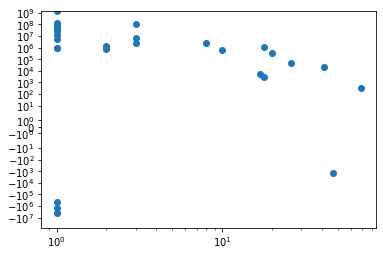

In [155]:
plt.scatter(profit_by_product["count"], profit_by_product["mean"])
plt.xscale("log")
plt.yscale("symlog")

<BarContainer object of 28 artists>

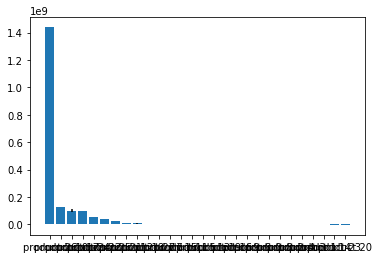

In [156]:
xvals = np.arange(len(profit_by_product))
width = 0.2
plt.bar(list(map(lambda x: f'product {x}', profit_by_product.index.to_list())), profit_by_product["mean"], yerr=profit_by_product["sem"].fillna(0))
#ax2 = plt.twinx()
#ax2.bar(xvals + width, profit_by_product["std"], width=width)

### Who Made a Profit?

In [157]:
print(len(np.where(((revenue - costs)) > 0)[0]))
np.where(((revenue - costs)) > 0)

129


(array([  0,   4,   5,   6,   7,   9,  10,  11,  12,  13,  15,  16,  17,
         18,  19,  21,  22,  24,  25,  26,  27,  31,  32,  37,  40,  43,
         45,  47,  48,  53,  54,  55,  58,  62,  63,  68,  72,  80,  81,
         84,  90,  93,  98, 105, 106, 107, 110, 114, 117, 119, 125, 127,
        134, 136, 139, 142, 143, 144, 145, 149, 151, 152, 153, 157, 158,
        159, 164, 165, 168, 170, 171, 176, 178, 181, 184, 186, 188, 190,
        191, 192, 193, 195, 198, 203, 206, 207, 210, 213, 215, 219, 221,
        222, 226, 227, 228, 230, 231, 232, 234, 236, 237, 238, 241, 242,
        246, 248, 249, 252, 258, 259, 261, 263, 264, 268, 269, 272, 273,
        275, 276, 277, 278, 279, 281, 283, 285, 286, 287, 288, 293]),)

In [158]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) > 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) > 0)

283


(array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  77,  78,  79,  80,  81,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  93,  94,  96,  97,  98,  99, 100,
        101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
        183, 184, 185, 186, 187, 188, 189, 190, 191

In [159]:
revenue[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False).head(10)

seller
26     1.968663e+09
27     3.631189e+08
24     3.225618e+08
22     2.469584e+08
21     2.307224e+08
10     1.929303e+08
40     1.483166e+08
17     1.210794e+08
219    9.935818e+07
25     8.520641e+07
Name: value, dtype: float64

In [160]:
costs[((revenue - costs) + value_of_goods_on_hand) > 0].sort_values(ascending=False)

buyer
26     5.299610e+08
27     3.581483e+08
24     2.231251e+08
21     2.050598e+08
22     1.929303e+08
           ...     
250    1.555381e+04
220    1.194410e+04
299    1.176000e+04
41     1.127322e+04
99     1.088742e+04
Name: value, Length: 283, dtype: float64

top profit takers

In [161]:
(revenue-costs).sort_values(ascending=False).head(20)

seller
26     1.438702e+09
10     1.242952e+08
40     1.214463e+08
17     1.000226e+08
24     9.943665e+07
219    7.764022e+07
22     5.402811e+07
25     3.751340e+07
21     2.566258e+07
12     1.139776e+07
37     6.540740e+06
18     6.145595e+06
234    6.029716e+06
136    5.817252e+06
237    5.706764e+06
27     4.970531e+06
263    3.568384e+06
15     3.422647e+06
84     3.340638e+06
45     2.812392e+06
Name: value, dtype: float64

In [162]:
agent_goods_df.loc[(revenue-costs).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

26     26
10     10
40     17
17     17
24     24
219    17
22     22
25     25
21     21
12     12
37     18
18     18
234    18
136     7
237     7
27     27
263     5
15     15
84      7
45      5
dtype: int64

Taking into account value of goods on hand:

In [163]:
(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20)

seller
26     1.440071e+09
24     2.217396e+08
10     1.267013e+08
40     1.217522e+08
17     1.001337e+08
219    7.813002e+07
22     6.016715e+07
25     3.818286e+07
21     3.518900e+07
19     1.857217e+07
12     1.139845e+07
37     7.474554e+06
18     6.714367e+06
234    6.241802e+06
136    5.889322e+06
237    5.778290e+06
27     4.970531e+06
15     4.170097e+06
23     3.788259e+06
263    3.591943e+06
dtype: float64

In [164]:
agent_goods_df.loc[(revenue-costs+value_of_goods_on_hand).sort_values(ascending=False).head(20).index.to_series()].idxmax(axis=1)

26     26
24     24
10     10
40     17
17     17
219    17
22     22
25     25
21     21
19     19
12     12
37     18
18     18
234    18
136     7
237     7
27     27
15     15
23     23
263     5
dtype: int64

### Who Made a Loss?

And selling what products?

In [165]:
print(len(np.where(((revenue - costs)) < 0)[0]))
np.where(((revenue - costs)) < 0)

171


(array([  1,   2,   3,   8,  14,  20,  23,  28,  29,  30,  33,  34,  35,
         36,  38,  39,  41,  42,  44,  46,  49,  50,  51,  52,  56,  57,
         59,  60,  61,  64,  65,  66,  67,  69,  70,  71,  73,  74,  75,
         76,  77,  78,  79,  82,  83,  85,  86,  87,  88,  89,  91,  92,
         94,  95,  96,  97,  99, 100, 101, 102, 103, 104, 108, 109, 111,
        112, 113, 115, 116, 118, 120, 121, 122, 123, 124, 126, 128, 129,
        130, 131, 132, 133, 135, 137, 138, 140, 141, 146, 147, 148, 150,
        154, 155, 156, 160, 161, 162, 163, 166, 167, 169, 172, 173, 174,
        175, 177, 179, 180, 182, 183, 185, 187, 189, 194, 196, 197, 199,
        200, 201, 202, 204, 205, 208, 209, 211, 212, 214, 216, 217, 218,
        220, 223, 224, 225, 229, 233, 235, 239, 240, 243, 244, 245, 247,
        250, 251, 253, 254, 255, 256, 257, 260, 262, 265, 266, 267, 270,
        271, 274, 280, 282, 284, 289, 290, 291, 292, 294, 295, 296, 297,
        298, 299]),)

In [166]:
print(len(np.where(((revenue - costs) + value_of_goods_on_hand) < 0)[0]))
np.where(((revenue - costs) + value_of_goods_on_hand) < 0)

17


(array([  8,  20,  36,  49,  50,  61,  76,  82,  92,  95, 109, 137, 162,
        172, 235, 270, 297]),)

In [167]:
(revenue-costs).sort_values(ascending=True).head(20)

seller
20    -4.160543e+06
23    -1.340852e+06
14    -4.102487e+05
177   -3.147642e+04
30    -1.437601e+04
161   -1.437571e+04
73    -1.259481e+04
271   -1.259255e+04
60    -4.799283e+03
250   -4.798877e+03
233   -4.798732e+03
175   -4.798690e+03
162   -4.798622e+03
50    -4.798616e+03
148   -4.798522e+03
82    -4.798509e+03
41    -4.798395e+03
95    -4.798226e+03
99    -4.798183e+03
86    -4.798046e+03
Name: value, dtype: float64

In [168]:
agent_goods_df[((revenue - costs)) < 0].idxmax(axis=1).head(20)

1      1
2      2
3      3
8      8
14    14
20    20
23    23
28     3
29     1
30     7
33     3
34     3
35     1
36     8
38     3
39     1
41     8
42     1
44     4
46     3
dtype: int64

In [169]:
(revenue-costs + value_of_goods_on_hand).sort_values(ascending=True).head(20)

seller
20    -1.308536e+06
137   -2.165644e+03
297   -2.165644e+03
61    -2.032265e+03
92    -2.014760e+03
172   -1.995272e+03
50    -1.950672e+03
76    -1.933999e+03
36    -1.933999e+03
49    -1.933999e+03
162   -1.908533e+03
8     -1.903618e+03
82    -1.902498e+03
95    -1.868745e+03
109   -1.276256e+03
235   -6.154576e+02
270   -1.609514e+02
99     7.381581e+01
41     1.411819e+02
52     4.307274e+02
dtype: float64

In [170]:
agent_goods_df[((revenue - costs) + value_of_goods_on_hand) < 0].idxmax(axis=1)

8       8
20     20
36      8
49      8
50      8
61      8
76      8
82      8
92      8
95      8
109     8
137     8
162     8
172     8
235     8
270     8
297     8
dtype: int64

## Recompute Profit from ending vs starting balance

And also account for value of goods on hand.

In [171]:
(balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]

agent
0      19260.717682
1       -965.722846
2      -2836.399246
3       -581.778892
4      18296.202810
           ...     
295    -1270.575460
296    -3324.102136
297    -4796.895812
298    -3322.726775
299    -4797.059318
Name: balance, Length: 300, dtype: float64

<AxesSubplot:>

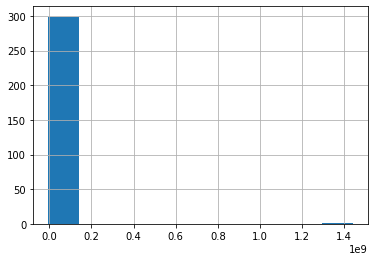

In [172]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"]).hist()

<AxesSubplot:>

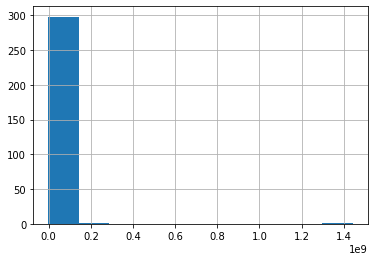

In [173]:
((balance_df[balance_df["tick"] == balance_df["tick"].max()].set_index("agent") - balance_df[balance_df["tick"] == balance_df["tick"].min()].set_index("agent"))["balance"] + value_of_goods_on_hand).hist()

## Profit By Prices

In [174]:
production_goods

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

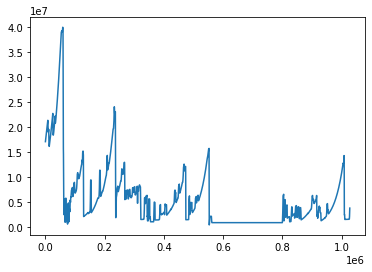

In [175]:
(buy_price_df[buy_price_df["agent"] == 26].drop(["agent", "tick"], axis=1) * production_goods.loc[26]).sum(axis=1).plot()

<AxesSubplot:>

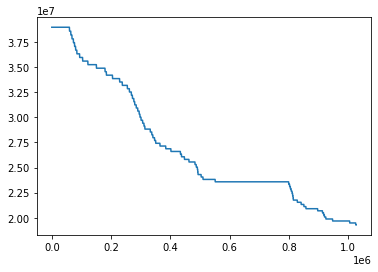

In [176]:
sell_price_df[sell_price_df["agent"] == 26][26].plot()

# Production Efficiency